In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD


from art.estimators.classification.deep_partition_ensemble import DeepPartitionEnsemble

# Load the Data

In [2]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 10000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

# Poison training data
percent_poison = .33
x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)

x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

# Initialize the Model Architecture

In [3]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
def create_model():    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Set up the Model Backdoor

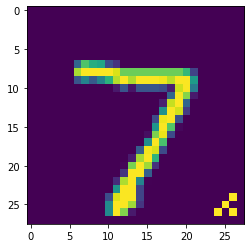

In [4]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
pdata, plabels = backdoor.poison(x_test, y=example_target)

plt.imshow(pdata[0].squeeze())

# Create the poison data
For this example, we will select 9 as the target class. Thus, the adversary's goal is to poison the model so adding a trigger will result in the trained model misclassifying the triggered input as a 9.

First, the adversary will create a proxy classifier (i.e., a classifier that is similar to the target classifier). As the clean label attack generates noise using PGD in order to encourage the trained classifier to rely on the trigger, it is important that the generated noise be transferable. Thus, adversarial training is used.

In [5]:
# Poison some percentage of all non-nines to nines
targets = to_categorical([9], 10)[0] 

proxy = AdversarialTrainerMadryPGD(KerasClassifier(create_model()), nb_epochs=10, eps=0.15, eps_step=0.001)
proxy.fit(x_train, y_train)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
attack = PoisoningAttackCleanLabelBackdoor(backdoor=backdoor, proxy_classifier=proxy.get_classifier(),
                                           target=targets, pp_poison=percent_poison, norm=2, eps=5,
                                           eps_step=0.1, max_iter=200)
pdata, plabels = attack.poison(x_train, y_train)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

957


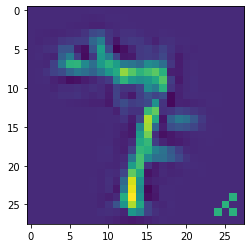

Index: 5 Label: 9


In [7]:
poisoned = pdata[np.all(plabels == targets, axis=1)]
poisoned_labels = plabels[np.all(plabels == targets, axis=1)]
print(len(poisoned))
for i in range(len(poisoned)):
    if poisoned[i][0][0] != 0:
        plt.imshow(poisoned[i].squeeze())
        plt.show()
        print(f"Index: {i} Label: {np.argmax(poisoned_labels[i])}")
        break

# Initialize the classification models
We will initialize four models. The first is a single model architecture. The other three are DPA models with varying ensemble sizes to demonstrate the tradeoff between clean accuracy and poison accuracy. This make take some time because of the model copying.

In [8]:
model = KerasClassifier(create_model())
dpa_model_10 = DeepPartitionEnsemble(model, ensemble_size=10)
dpa_model_20 = DeepPartitionEnsemble(model, ensemble_size=20)
dpa_model_30 = DeepPartitionEnsemble(model, ensemble_size=30)


Train the models on the poisoned data

In [9]:
model.fit(pdata, plabels, nb_epochs=10)
dpa_model_10.fit(pdata, plabels, nb_epochs=10)
dpa_model_20.fit(pdata, plabels, nb_epochs=10)
dpa_model_30.fit(pdata, plabels, nb_epochs=10)

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 105us/sample - loss: 0.6879 - accuracy: 0.7870
Epoch 2/10
10000/10000 [==============================] - 1s 51us/sample - loss: 0.2275 - accuracy: 0.9339
Epoch 3/10
10000/10000 [==============================] - 1s 52us/sample - loss: 0.1439 - accuracy: 0.9557
Epoch 4/10
10000/10000 [==============================] - 1s 51us/sample - loss: 0.1099 - accuracy: 0.9675
Epoch 5/10
10000/10000 [==============================] - 1s 51us/sample - loss: 0.0875 - accuracy: 0.9743
Epoch 6/10
10000/10000 [==============================] - 1s 51us/sample - loss: 0.0712 - accuracy: 0.9793
Epoch 7/10
10000/10000 [==============================] - 1s 52us/sample - loss: 0.0681 - accuracy: 0.9777
Epoch 8/10
10000/10000 [==============================] - 1s 51us/sample - loss: 0.0467 - accuracy: 0.9847
Epoch 9/10
10000/10000 [==============================] - 1s 51us/sample - loss: 0.0424 - accuracy: 0.9876
Epoch 10/10
1

975/975 [==============================] - 0s 54us/sample - loss: 0.2622 - accuracy: 0.9159
Epoch 8/10
975/975 [==============================] - 0s 54us/sample - loss: 0.2129 - accuracy: 0.9333
Epoch 9/10
975/975 [==============================] - 0s 54us/sample - loss: 0.1677 - accuracy: 0.9487
Epoch 10/10
975/975 [==============================] - 0s 54us/sample - loss: 0.1530 - accuracy: 0.9579
Train on 1028 samples
Epoch 1/10
1028/1028 [==============================] - 9s 9ms/sample - loss: 1.8419 - accuracy: 0.4037
Epoch 2/10
1028/1028 [==============================] - 0s 58us/sample - loss: 0.9608 - accuracy: 0.6839
Epoch 3/10
1028/1028 [==============================] - 0s 57us/sample - loss: 0.7111 - accuracy: 0.7626
Epoch 4/10
1028/1028 [==============================] - 0s 57us/sample - loss: 0.5721 - accuracy: 0.8200
Epoch 5/10
1028/1028 [==============================] - 0s 57us/sample - loss: 0.4415 - accuracy: 0.8512
Epoch 6/10
1028/1028 [==============================

520/520 [==============================] - 0s 59us/sample - loss: 0.8937 - accuracy: 0.7058
Epoch 5/10
520/520 [==============================] - 0s 66us/sample - loss: 0.7529 - accuracy: 0.7269
Epoch 6/10
520/520 [==============================] - 0s 59us/sample - loss: 0.6097 - accuracy: 0.7962
Epoch 7/10
520/520 [==============================] - 0s 62us/sample - loss: 0.5666 - accuracy: 0.8096
Epoch 8/10
520/520 [==============================] - 0s 60us/sample - loss: 0.4816 - accuracy: 0.8481
Epoch 9/10
520/520 [==============================] - 0s 58us/sample - loss: 0.3869 - accuracy: 0.8673
Epoch 10/10
520/520 [==============================] - 0s 60us/sample - loss: 0.3678 - accuracy: 0.8808
Train on 503 samples
Epoch 1/10
503/503 [==============================] - 10s 19ms/sample - loss: 2.1470 - accuracy: 0.2903
Epoch 2/10
503/503 [==============================] - 0s 57us/sample - loss: 1.4585 - accuracy: 0.5964
Epoch 3/10
503/503 [==============================] - 0s 55us

476/476 [==============================] - 1s 1ms/sample - loss: 2.1658 - accuracy: 0.2605
Epoch 2/10
476/476 [==============================] - 0s 88us/sample - loss: 1.5388 - accuracy: 0.5399
Epoch 3/10
476/476 [==============================] - 0s 60us/sample - loss: 1.0840 - accuracy: 0.6450
Epoch 4/10
476/476 [==============================] - 0s 55us/sample - loss: 0.8079 - accuracy: 0.7269
Epoch 5/10
476/476 [==============================] - 0s 56us/sample - loss: 0.6481 - accuracy: 0.7773
Epoch 6/10
476/476 [==============================] - 0s 54us/sample - loss: 0.4718 - accuracy: 0.8466
Epoch 7/10
476/476 [==============================] - 0s 56us/sample - loss: 0.4352 - accuracy: 0.8550
Epoch 8/10
476/476 [==============================] - 0s 62us/sample - loss: 0.3376 - accuracy: 0.8845
Epoch 9/10
476/476 [==============================] - 0s 57us/sample - loss: 0.3099 - accuracy: 0.9013
Epoch 10/10
476/476 [==============================] - 0s 56us/sample - loss: 0.3038 

488/488 [==============================] - 0s 55us/sample - loss: 0.3812 - accuracy: 0.8689
Epoch 10/10
488/488 [==============================] - 0s 55us/sample - loss: 0.2635 - accuracy: 0.9057
Train on 309 samples
Epoch 1/10
309/309 [==============================] - 10s 34ms/sample - loss: 2.2287 - accuracy: 0.1586
Epoch 2/10
309/309 [==============================] - 0s 65us/sample - loss: 1.8008 - accuracy: 0.5275
Epoch 3/10
309/309 [==============================] - 0s 61us/sample - loss: 1.2902 - accuracy: 0.6343
Epoch 4/10
309/309 [==============================] - 0s 61us/sample - loss: 0.8978 - accuracy: 0.7508
Epoch 5/10
309/309 [==============================] - 0s 62us/sample - loss: 0.7633 - accuracy: 0.7670
Epoch 6/10
309/309 [==============================] - 0s 62us/sample - loss: 0.6468 - accuracy: 0.7896
Epoch 7/10
309/309 [==============================] - 0s 64us/sample - loss: 0.5144 - accuracy: 0.8220
Epoch 8/10
309/309 [==============================] - 0s 62us

321/321 [==============================] - 0s 61us/sample - loss: 0.6457 - accuracy: 0.7819
Epoch 7/10
321/321 [==============================] - 0s 79us/sample - loss: 0.5311 - accuracy: 0.8255
Epoch 8/10
321/321 [==============================] - 0s 64us/sample - loss: 0.4651 - accuracy: 0.8505
Epoch 9/10
321/321 [==============================] - 0s 60us/sample - loss: 0.4384 - accuracy: 0.8442
Epoch 10/10
321/321 [==============================] - 0s 60us/sample - loss: 0.3757 - accuracy: 0.8660
Train on 337 samples
Epoch 1/10
337/337 [==============================] - 11s 33ms/sample - loss: 2.2155 - accuracy: 0.2226
Epoch 2/10
337/337 [==============================] - 0s 66us/sample - loss: 1.7212 - accuracy: 0.4866
Epoch 3/10
337/337 [==============================] - 0s 71us/sample - loss: 1.2952 - accuracy: 0.5727
Epoch 4/10
337/337 [==============================] - 0s 61us/sample - loss: 0.9156 - accuracy: 0.6736
Epoch 5/10
337/337 [==============================] - 0s 61us

329/329 [==============================] - 0s 73us/sample - loss: 1.3702 - accuracy: 0.6292
Epoch 4/10
329/329 [==============================] - 0s 63us/sample - loss: 1.0237 - accuracy: 0.6748
Epoch 5/10
329/329 [==============================] - 0s 63us/sample - loss: 0.7861 - accuracy: 0.7690
Epoch 6/10
329/329 [==============================] - 0s 61us/sample - loss: 0.6595 - accuracy: 0.7933
Epoch 7/10
329/329 [==============================] - 0s 61us/sample - loss: 0.5333 - accuracy: 0.8055
Epoch 8/10
329/329 [==============================] - 0s 61us/sample - loss: 0.4790 - accuracy: 0.8480
Epoch 9/10
329/329 [==============================] - 0s 62us/sample - loss: 0.4028 - accuracy: 0.8754
Epoch 10/10
329/329 [==============================] - 0s 62us/sample - loss: 0.3721 - accuracy: 0.8815
Train on 330 samples
Epoch 1/10
330/330 [==============================] - 12s 35ms/sample - loss: 2.2205 - accuracy: 0.2061
Epoch 2/10
330/330 [==============================] - 0s 68us

Epoch 1/10
344/344 [==============================] - 1s 2ms/sample - loss: 2.1742 - accuracy: 0.2703
Epoch 2/10
344/344 [==============================] - 0s 62us/sample - loss: 1.7170 - accuracy: 0.5262
Epoch 3/10
344/344 [==============================] - 0s 62us/sample - loss: 1.1922 - accuracy: 0.6279
Epoch 4/10
344/344 [==============================] - 0s 62us/sample - loss: 0.8721 - accuracy: 0.7413
Epoch 5/10
344/344 [==============================] - 0s 61us/sample - loss: 0.7089 - accuracy: 0.7616
Epoch 6/10
344/344 [==============================] - 0s 62us/sample - loss: 0.6076 - accuracy: 0.7936
Epoch 7/10
344/344 [==============================] - 0s 61us/sample - loss: 0.4682 - accuracy: 0.8517
Epoch 8/10
344/344 [==============================] - 0s 65us/sample - loss: 0.4702 - accuracy: 0.8605
Epoch 9/10
344/344 [==============================] - 0s 61us/sample - loss: 0.3856 - accuracy: 0.8605
Epoch 10/10
344/344 [==============================] - 0s 61us/sample - lo

# Evaluate the performance of the trained models on unpoisoned data
The performance of the models appears normal. We see that for the DPA models, the performance drops slightly as the ensemble size increases


Clean test set accuracy (model): 98.21%


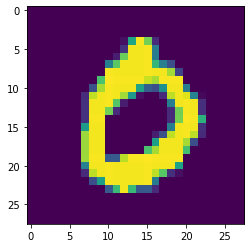

Prediction: 0


In [10]:
clean_preds = np.argmax(model.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (model): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model_10): 93.99%


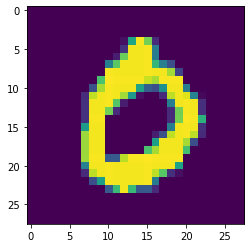

Prediction: 0


In [11]:
clean_preds = np.argmax(dpa_model_10.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_10): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model_20): 91.27%


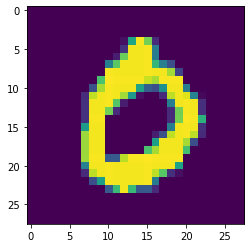

Prediction: 0


In [12]:
clean_preds = np.argmax(dpa_model_20.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_20): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model_30): 89.95%


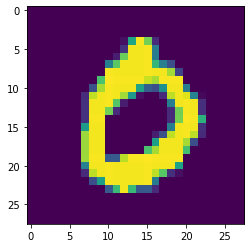

Prediction: 0


In [13]:
clean_preds = np.argmax(dpa_model_30.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_30): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

# Evaluate the performance of the trained models on poisoned data
When the trigger is added, we see a shift in performance. The single model performs the worst as no defense is in place to mitigate the effect of the poisoned. The DPA models show some robustnesss to the poison as they partition the training data, which spreads the effect of the poison between models in the ensemble.


Poison test set accuracy (model): 0.04%


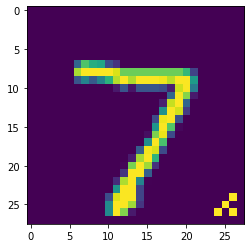

Prediction: 9


In [14]:
not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])

poison_preds = np.argmax(model.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (model): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))


Poison test set accuracy (DPA model_10): 70.06%


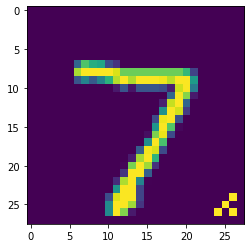

Prediction: 7


In [15]:
poison_preds = np.argmax(dpa_model_10.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_10): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))


Poison test set accuracy (DPA model_20): 72.86%


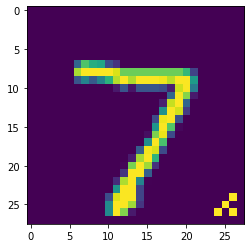

Prediction: 7


In [16]:
poison_preds = np.argmax(dpa_model_20.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_20): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))


Poison test set accuracy (DPA model_30): 73.68%


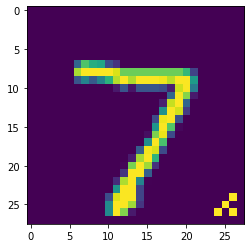

Prediction: 7


In [17]:
poison_preds = np.argmax(dpa_model_30.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_30): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))